In [1]:
import numpy as np
np.set_printoptions(formatter={'float': '{:.6E}'.format})
import os
import matplotlib.pyplot as plt
os.environ["OMP_NUM_THREADS"] = "1"

# Integration functions and QR decomposition
%run ./Functions.ipynb

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25

## Overview

We compute the first N_exp largest Lyapunov exponents of the Lorenz system.

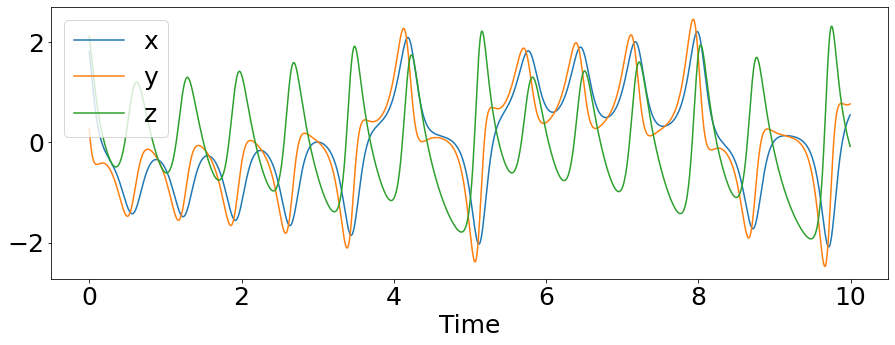

In [2]:
##### Initialize
N_dim     = 3          #Degrees of freedom of the system
N_exp     = 3          #Number of exponents to compute

dt        = .005       #timestep

N_orth    = 10         #the cost of orthonormalizing is significantly smaller than solving the equations,
                       #we can therefore orthonormalize often with little increase in computational time

N         = 500000     #length of time series
N_times   = N//N_orth  #total number of orthonormalizations
N_print   = 10         #total number of printed updates during computation

integrator = RK4       #integration scheme
system     = Lorenz    #Right hand side of the governing equations

N_transient = int(100/dt)                          #integration points to reach the attractor
q0          = np.random.random((N_dim))            #random initial condition
q0          = integrator(q0,dt,N_transient,system) #unperturbed initial condition on the attractor 

N_temp      = int(10/dt)
q_temp      = np.empty((N_temp, N_dim))
q_temp[0]   = q0
for i in range(1,N_temp):
    q_temp[i] = integrator(q_temp[i-1],dt,1,system) #brief trajectory along the attractor

# to visually check the signal, useful for limit cycles and quasiperiodic solutions
lines = plt.plot(np.arange(N_temp)*dt, (q_temp-q_temp.mean(axis=0))/np.std(q_temp,axis=0))
plt.xlabel('Time')
plt.legend(lines, ('x', 'y', 'z'))
plt.show()

qtemp_norm  = np.mean(np.linalg.norm(q_temp, axis=1))
eps         = 1.e-9*qtemp_norm                    #multiplication factor to make perturbations infinitesimal

SS          = np.empty((N_times, N_exp))          #initialize lyapunov exponents
q0P         = []                                  #initialize perturbations
for ii in range(N_exp):
    q_per    = np.random.rand(N_dim)
    q0P     += [ q0 + eps*(q_per/np.linalg.norm(q_per)) ]      #N_exp randomly perturbed initial conditions

### Algorithm
The first N_exp largest Lyapunov exponents are computed by letting the unperturbed trajectory plus N_exp perturbed trajectories evolve according to the non linear equations.

The evolution of the perturbations is computed as the difference between the perturbed trajectories and the unperturbed trajectory.

Every N_orth integration steps, we orthornormalize the perturbations to compute an orthonormal basis that spans the N_exp-dimensional subspace. 

The average exponential rate of change of the norm of the perturbations along the element of the orthonormal basis provides the largest N_exp Lyapunov exponents.

In [3]:
%%time
#### Compute lyapunov exponents

S = 0
for jj in range(N_times):
    
    if jj > 0:
        q0P = [q0 + eps*x_i for x_i in x_norm]               #perturb initial condition with orthonormal basis
    
    q0   = integrator(q0,dt,N_orth,system)                   #compute unperturbed trajectory                   
    q0P  = [integrator(qP,dt,N_orth,system) for qP in q0P]   #compute perturbed trajectories
            
    x    = [(qP - q0) for qP in q0P]                         #compute perturbations
    
    x_norm, S1 = QR(x/eps, N_exp)                            #orthornormalize basis and compute exponents
    
    if jj > 0:                                               #skip the first step, which does not start from the orthonormalized basis
        S       += S1
        SS[jj]   = S/(jj*dt*N_orth)
        if jj%(N_times//N_print) == 0: print('Lyapunov exponents, completion percentage:',
                                        SS[jj], jj/N_times)   
    

Lyapunov exponents, completion percentage: [9.093505E-01 3.079904E-03 -1.457909E+01] 0.1
Lyapunov exponents, completion percentage: [9.047304E-01 4.360132E-04 -1.457183E+01] 0.2
Lyapunov exponents, completion percentage: [9.053738E-01 -4.486956E-04 -1.457159E+01] 0.3
Lyapunov exponents, completion percentage: [9.038360E-01 -1.286233E-03 -1.456921E+01] 0.4
Lyapunov exponents, completion percentage: [9.004449E-01 4.244053E-04 -1.456753E+01] 0.5
Lyapunov exponents, completion percentage: [9.014000E-01 -4.602449E-04 -1.456760E+01] 0.6
Lyapunov exponents, completion percentage: [9.005081E-01 -2.661380E-04 -1.456690E+01] 0.7
Lyapunov exponents, completion percentage: [9.021594E-01 1.019045E-04 -1.456892E+01] 0.8
Lyapunov exponents, completion percentage: [9.055999E-01 -1.452762E-04 -1.457212E+01] 0.9
CPU times: user 35.6 s, sys: 200 ms, total: 35.8 s
Wall time: 35.6 s


In [4]:
## Compute Kaplan-Yorke dimension
Lyap_exp    = SS[-1]
Uncertainty = np.max(np.abs((SS[-N_times//N_print:]-SS[-1])),axis=0)
print('Lyapunov exponents      ', Lyap_exp)
print('Uncertainty           +-', Uncertainty)

if Lyap_exp.sum() > 0:
    print('Error: not enough exponents have been computed. Increase N_exp to compute KY-dimension')

else:
    #for periodic and quasiperiodic solutions
    for i in range(N_exp):
        if np.abs(Lyap_exp[i]) < 1e-3: Lyap_exp[i] = np.abs(Lyap_exp[i])
    
    sums = np.cumsum(Lyap_exp) #cumulative sum of the Lyapunov exponents
    arg  = np.argmax(sums<0)   #index for which the cumulative sum becomes negative

    KY_dim = arg + sums[arg-1] / np.abs(Lyap_exp[arg])
    
    print('Kaplan-Yorke dimension  ', KY_dim)

Lyapunov exponents       [9.041720E-01 4.783538E-05 -1.457088E+01]
Uncertainty           +- [4.652579E-03 1.055672E-03 3.622419E-03]
Kaplan-Yorke dimension   2.0620566380121743


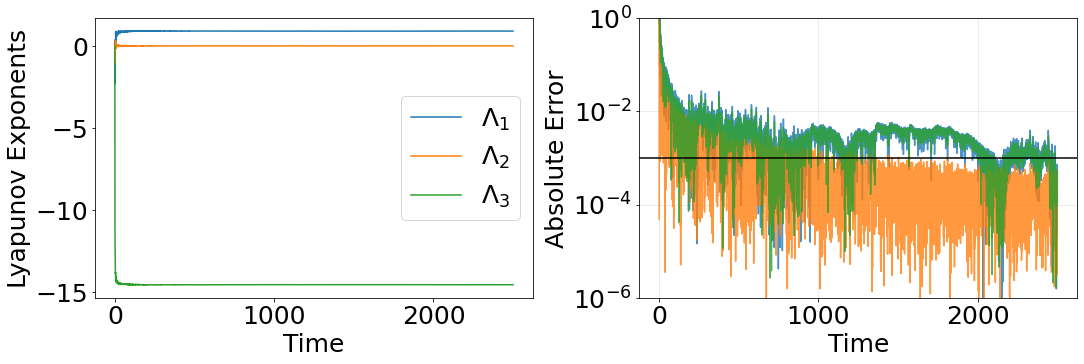

In [5]:
### Plot convergence of the exponents

plot_skips = 10

plt.subplot(121)
lines = plt.plot(np.arange(N_times)[::plot_skips]*dt*N_orth, SS[::plot_skips])
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponents')
plt.legend(lines, ('$\Lambda_1$', '$\Lambda_2$', '$\Lambda_3$'))

plt.subplot(122)
plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.plot(np.arange(N_times)[::plot_skips]*dt*N_orth, np.abs((SS-SS[-1]))[::plot_skips], alpha=.8)
#horizontal line indicates 0.001 
plt.axhline(1e-3, c='k', zorder=10)
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.ylim(1e-6,1e0)
plt.tight_layout(pad=0.2, w_pad=.5)
plt.show()